In [4]:
#Importing image and excel datas

folder_image = '/kaggle/input/glioma-mri/glioma'
folder_csv = pd.read_csv('/kaggle/input/glioma-csv1/MU-Glioma-Post_ClinicalData-FINAL032025.csv')



folder_csv['Patient_ID'] = folder_csv['Patient_ID'].astype(str)

# Extract and define tabular input features  and  outputs 
csv_features = folder_csv[['Sex at Birth', 'Race', 'Age at diagnosis']].values
csv_outputs = folder_csv[['Primary Diagnosis', 'Second Progression/Recurrence', 'IDH1 mutation', 'IDH2 mutation','MGMT methylation']].values



#Sorting image inputs  and  their coresponding masks 

mask_list = []
image_list = []


for paths, dirs, files in os.walk(folder_image):
    for file in files:
        if 'tumorMask' in file:
             mask_list.append(os.path.join(paths, file))

             

        else :
              image_list.append(os.path.join(paths, file))



image_list.sort(key= natural_sort)

mask_list.sort(key= natural_sort)

print(len(image_list))
print(len(mask_list))

sample_image = nib.load(image_list[2]).get_fdata()
sample_mask = nib.load(mask_list[2]).get_fdata()

print("Image shape:", sample_image.shape)
print("Mask shape:", sample_mask.shape)

image_array = []
mask_array = []

# Choosing a common target shape 
target_shape = (112, 112, 64)

for image_path, mask_path in zip(image_list, mask_list):
    img_nii = nib.load(image_path)
    mask_nii = nib.load(mask_path)

    img = img_nii.get_fdata()
    mask = mask_nii.get_fdata()

    # Normalize image
    if np.max(img) != 0:
        img = img / np.max(img)

    # Compute zoom factors
    zoom_factors = (
        target_shape[0] / img.shape[0],
        target_shape[1] / img.shape[1],
        target_shape[2] / img.shape[2],
    )




    img_resized = zoom(img, zoom=zoom_factors, order=1)      # Linear interpolation
    mask_resized = zoom(mask, zoom=zoom_factors, order=0)    # Nearest neighbor for masks

    # Binarize mask
    mask_resized = (mask_resized > 0.5).astype(np.float32)

    image_array.append(img_resized.astype(np.float32))
    mask_array.append(mask_resized.astype(np.float32))



image_array = np.expand_dims(np.array(image_array), -1)  
mask_array = np.expand_dims(np.array(mask_array), -1)

print("Image shape:", image_array.shape)
print("Mask shape:", mask_array.shape)


# Extract and print patient IDs from images and masks
image_ids = [extract_id(p) for p in image_list]
mask_ids = [extract_id(p) for p in mask_list]

# Print a few samples
print("Sample image IDs:", image_ids[:5])
print("Sample mask IDs:", mask_ids[:5])

image_ids = [extract_id(p) for p in image_list]
mask_ids = [extract_id(p) for p in mask_list]


csv_ids = folder_csv['Patient_ID'].tolist()
unmatched = [pid for pid in image_ids if pid not in csv_ids]
print("IDs not found in CSV:", unmatched)
# Keep only image/mask pairs whose ID exists in the CSV
valid_indexes = [i for i, pid in enumerate(image_ids) if pid in csv_ids]

# Filter arrays
image_array = image_array[valid_indexes]
mask_array = mask_array[valid_indexes]
valid_ids = [image_ids[i] for i in valid_indexes]

# Align CSV with filtered IDs
csv_aligned = folder_csv[folder_csv['Patient_ID'].isin(valid_ids)]
csv_aligned = csv_aligned.set_index('Patient_ID').loc[valid_ids]  
categorical = pd.get_dummies(csv_aligned[['Sex at Birth', 'Race']], drop_first=False)
categoricalb = pd.DataFrame(LabelEncoder().fit_transform(csv_aligned["Primary Diagnosis"]), columns=["Primary Diagnosis"])
csv_outputs = pd.concat([categoricalb, csv_aligned[['Second Progression/Recurrence', 'IDH1 mutation', 'IDH2 mutation', 'MGMT methylation']].reset_index(drop=True)], axis=1)
csv_features = pd.concat([categorical, csv_aligned[['Age at diagnosis']]], axis=1).astype(np.float32)

print("Final tabular feature shape:", csv_features.shape)
print("Final csv output shape:", csv_outputs.shape)




202
202
Image shape: (240, 240, 155)
Mask shape: (240, 240, 155)
Image shape: (202, 112, 112, 64, 1)
Mask shape: (202, 112, 112, 64, 1)
Sample image IDs: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007']
Sample mask IDs: ['PatientID_0003', 'PatientID_0004', 'PatientID_0005', 'PatientID_0006', 'PatientID_0007']
IDs not found in CSV: []
Final tabular feature shape: (202, 7)
Final csv output shape: (202, 5)


In [5]:
#Creating tensorflow dataset pipline for model training 

with strategy.scope():


     print("Final tabular output shape:", csv_outputs.shape)
     csv_outputs_np = csv_outputs.values
     primary_diag = csv_outputs_np[:, 0]
     second_prog = csv_outputs_np[:, 1]
     idh1_mut = csv_outputs_np[:, 2]
     idh2_muta = csv_outputs_np[:, 3]
     mgmt_metha = csv_outputs_np[:, 4]

     mgmt_metha = np.where(mgmt_metha == 4, 3, mgmt_metha)
     mgmt_meth = tf.one_hot(mgmt_metha.astype(int), depth=4)
     idh2_mut = tf.one_hot((idh2_muta == 2).astype(int), depth=2)


     # Find class weights in imbalanced outputs

     classes = np.unique(primary_diag)
     weights = compute_class_weight(class_weight='balanced', classes=classes, y=primary_diag)
     print(weights)
     classesb = np.unique(idh1_mut)
     weightsb = compute_class_weight(class_weight='balanced', classes=classesb, y=idh1_mut)
     print(weightsb)


     
     outputs = (mask_array, primary_diag, second_prog, idh1_mut, idh2_mut, mgmt_meth)


     ddata = tf.data.Dataset.from_tensor_slices(((image_array, csv_features), outputs))


     




     ddata = ddata.shuffle(buffer_size=400, seed=None)


     total_size = len(ddata)
     train_size = int(0.797 * total_size)
     val_size = int(0.1 * total_size)
     test_size = total_size - train_size - val_size  


     train_ds = ddata.take(train_size)
     remaining = ddata.skip(train_size)
     val_ds = remaining.take(val_size)
     test_ds = remaining.skip(val_size)


     train_ds = train_ds.batch(4)
     val_ds = val_ds.batch(4)
     test_ds = test_ds.batch(4)


     print(f"Train size: {train_size}")
     print(f"Validation size: {val_size}")
     print(f"Test size: {test_size}")



Final tabular output shape: (202, 5)
[ 1.24691358  3.36666667  0.21443737 33.66666667  8.41666667 11.22222222]
[0.41563786 2.49382716 5.17948718]
Train size: 160
Validation size: 20
Test size: 22


In [6]:
#showing the final shape and type of inputs and outputs


print('Image input shape:', image_array.shape, image_array.dtype)

print('Non-image input type:', type(csv_features))
print('Non-image input shape:', csv_features.shape)
print('Non-image input dtypes:\n', csv_features.dtypes)

csv_features_array = csv_features.to_numpy()
print('Non-image input array shape:', csv_features_array.shape)
print('Non-image input array dtype:', csv_features_array.dtype)

print('Mask output shape:', mask_array.shape, mask_array.dtype, 'unique:', np.unique(mask_array))
print('Primary diag labels shape:', primary_diag.shape, primary_diag.dtype, 'unique:', np.unique(primary_diag))
print('Second prog labels shape:', second_prog.shape, second_prog.dtype, 'unique:', np.unique(second_prog))
print('IDH1 mut labels shape:', idh1_mut.shape, idh1_mut.dtype, 'unique:', np.unique(idh1_mut))
print('IDH2 mut labels shape:', idh2_mut.shape, idh2_mut.dtype, 'unique:', np.unique(idh2_mut))
print('MGMT meth labels shape:', mgmt_meth.shape, mgmt_meth.dtype, 'unique:', np.unique(mgmt_meth))

Image input shape: (202, 112, 112, 64, 1) float32
Non-image input type: <class 'pandas.core.frame.DataFrame'>
Non-image input shape: (202, 7)
Non-image input dtypes:
 Sex at Birth_Female               float32
Sex at Birth_Male                 float32
Race_Asian                        float32
Race_Black or African American    float32
Race_Unknown                      float32
Race_White                        float32
Age at diagnosis                  float32
dtype: object
Non-image input array shape: (202, 7)
Non-image input array dtype: float32
Mask output shape: (202, 112, 112, 64, 1) float32 unique: [0. 1.]
Primary diag labels shape: (202,) float64 unique: [0. 1. 2. 3. 4. 5.]
Second prog labels shape: (202,) float64 unique: [0. 1.]
IDH1 mut labels shape: (202,) float64 unique: [0. 1. 2.]
IDH2 mut labels shape: (202, 2) <dtype: 'float32'> unique: [0. 1.]
MGMT meth labels shape: (202, 4) <dtype: 'float32'> unique: [0. 1.]


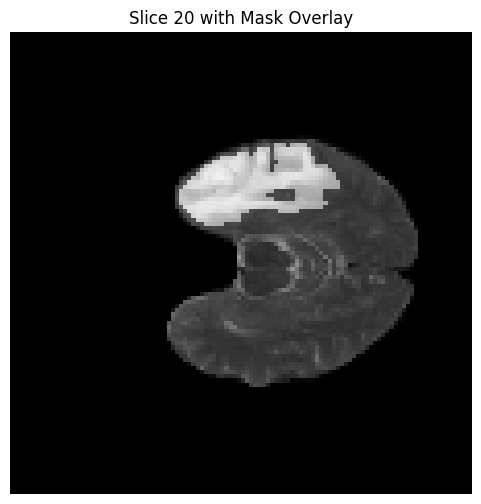

In [9]:

# Example: Show 20nd axial slice from the 70th sample
def show_overlay(image, mask, slice_index=20, alpha=0.4):

   
    image = np.squeeze(image)
    mask = np.squeeze(mask)
    
    img_slice = image[:, :, slice_index]
    mask_slice = mask[:, :, slice_index]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(mask_slice, cmap='gray', alpha=alpha)  # red mask overlay
    plt.title(f"Slice {slice_index} with Mask Overlay")
    plt.axis('off')
    plt.show()

show_overlay(image_array[70], mask_array [70] ,slice_index=20)


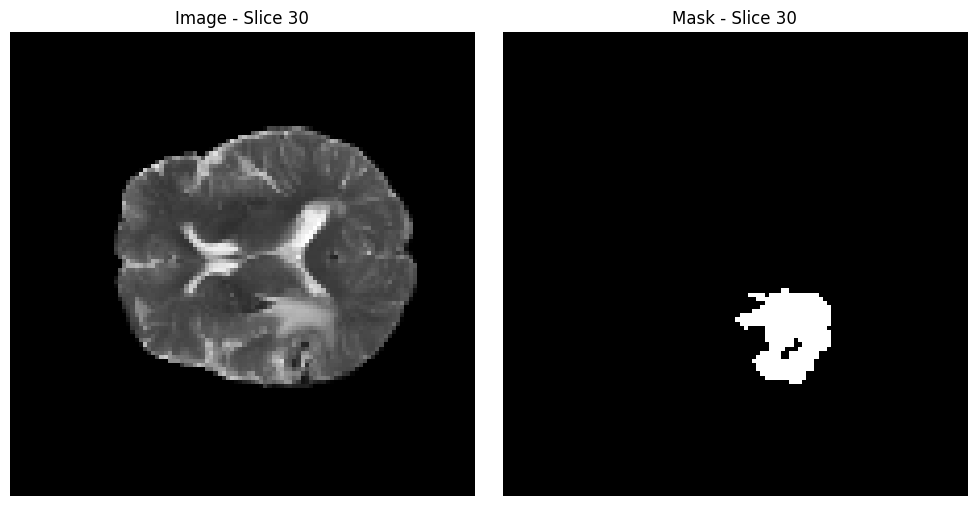

In [10]:
# Example: Show the 30nd slice from sample 77th

def show_image_and_mask(image, mask, slice_index=32):

    image = np.squeeze(image)
    mask = np.squeeze(mask)

    img_slice = image[:, :, slice_index]
    mask_slice = mask[:, :, slice_index]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_slice, cmap='gray')
    plt.title(f'Image - Slice {slice_index}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_slice, cmap='gray')
    plt.title(f'Mask - Slice {slice_index}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example: Show the 32nd slice from sample 0
show_image_and_mask(image_array[77], mask_array[77], slice_index=30)
